<a href="https://colab.research.google.com/github/tsayula/Capstone/blob/main/Final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ship Image Classification using Neural Networks 

##Overview

Among growing tension worldwide, there are a range of problems surfacing off the shores of virtually every ocean-adjacent country. 
This include overfishing, piracy, military encroachment, and the violation of exclusive economic zones. Billions of dollars are lost every year in an effort to combat these issues.  

##Business Problem/Use Case

Naturally, the ability to recognize and distinguish different kinds of ships can go a long way in preventing or at least more efficently dealing with these types of problems. 
The goal of this project is to be able to correctly identify the type of marine vessel based on the image using Convolutional Neural Networks.



##Data Understanding

The data consisted of a total of 6,252 images from Kaggle. The target variable is broken down into 5 categories.

Convolutional Neural Network (CNN) models will be created in order to train on the data. These models will be evaluated using accuracy scores to stress the 
importance of minimizing false positives. In this case false positives could be determinal to a high stakes situation where a carrier ship is incorrectly identified as a military ship which could lead to disastrous consequences.


____

###Mounting the Drive to load the data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
#downloading the data from Kaggle

# !kaggle datasets download -d arpitjain007/game-of-deep-learning-ship-datasets

In [ ]:
# #unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip


In [ ]:
!ls

Countplot_cat.png		       training_val_accuracy_sm.png
kaggle.json			       training_val_accuracy_vgg16.png
sample_submission_ns2btKE.csv	       training_val_loss_mobilenetv2.png
test_ApKoW4T.csv		       training_val_loss_vgg16.png
train				       vgg16_1.h5
training_val_accuracy_mobilenetv2.png  weights_FT.h5
training_val_accuracy_.png


In [ ]:
import pandas as pd
import numpy as np
import keras_preprocessing.image

In [ ]:
import sys
import os
import random
from pathlib import Path

In [ ]:
# Image Processing
import imageio
import cv2
import skimage.transform

# Charts
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')
%matplotlib inline


# ML, Statistics
import scipy
import tensorflow as tf
from tensorflow import data
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import regularizers, optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#Pretrained models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread


##Data Preparation


*   Import Data
*   Create Directory for data
*   Examine images











In [ ]:
import os
print(os.listdir("/content/gdrive/My Drive/Kaggle"))

['sample_submission_ns2btKE.csv', 'test_ApKoW4T.csv', 'kaggle.json', 'train', 'vgg16_1.h5', 'training_val_accuracy_.png', 'training_val_accuracy_vgg16.png', 'training_val_loss_vgg16.png', 'training_val_accuracy_mobilenetv2.png', 'training_val_loss_mobilenetv2.png', 'training_val_accuracy_sm.png', 'Countplot_cat.png', 'weights_FT.h5']


In [ ]:

ship_images= (os.listdir("/content/gdrive/My Drive/Kaggle/train/images"))


In [ ]:
#lets see what our data looks like
ship_labels= pd.read_csv('train/train.csv')
ship_labels.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:

ship_labels.head(5)

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [ ]:
#examining class imbalance
ship_labels['category'].value_counts()

1    2120
5    1217
2    1167
3     916
4     832
Name: category, dtype: int64

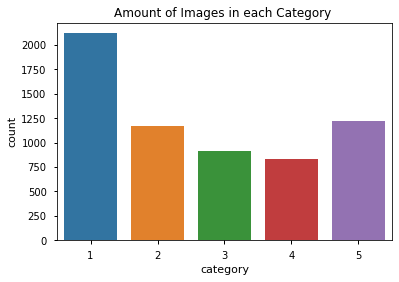

In [ ]:
# Visualizing class imbalance
sns.countplot(x='category' , data=ship_labels).set_title('Amount of Images in each Category ')
plt.savefig('Countplot_cat.png');

In [ ]:
train_df

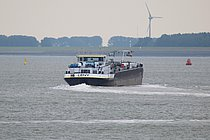

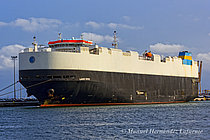

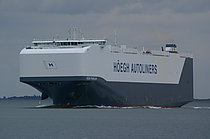

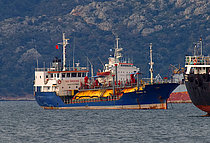

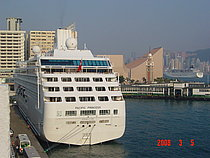

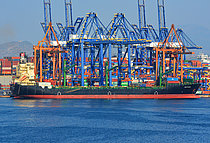

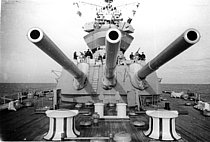

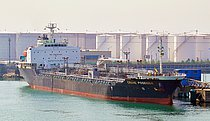

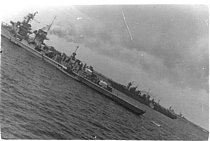

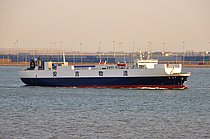

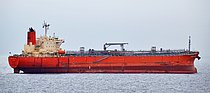

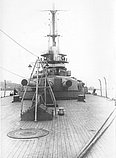

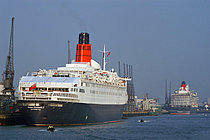

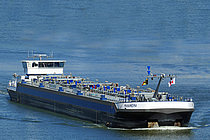

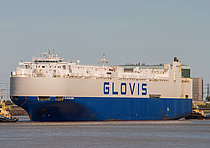

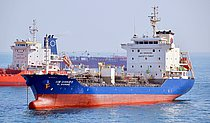

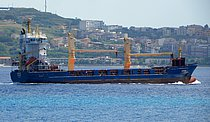

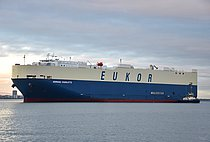

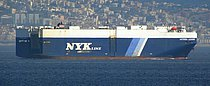

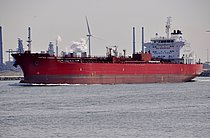

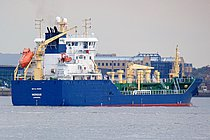

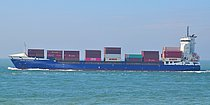

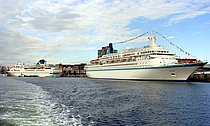

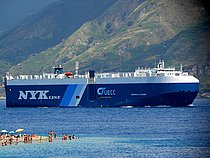

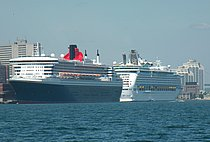

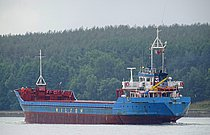

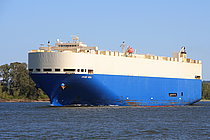

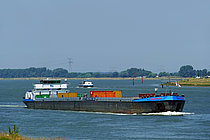

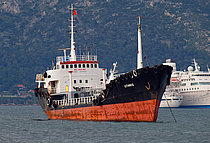

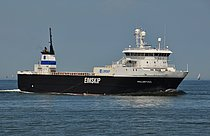

In [ ]:
#lets take a look at some of the images in the dataset
ship_images
for i in ship_images[:30]:
  y = cv2.imread('/content/gdrive/My Drive/Kaggle/train/images/'+i , 1)
  cv2_imshow(y)

In [ ]:
ships_dict= {'Cargo': 1, 
'Military': 2, 
'Carrier': 3, 
'Cruise': 4, 
'Tanker': 5}

In [ ]:
ships_dict

{'Cargo': 1, 'Carrier': 3, 'Cruise': 4, 'Military': 2, 'Tanker': 5}

In [ ]:

for k,v in ships_dict.items():
  print(k)

Cargo
Military
Carrier
Cruise
Tanker


In [ ]:
ships_dict= {k:v for v,k in ships_dict.items()}
ships_dict

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}

In [ ]:
# train_df['category']=train_df['category'].map(ships_dict)

##Splitting Data into Train and Validations Sets
In order to set up the our Deep Learning models, we need to first do a train test split so that we have a way to validate the models. Although we will create training and testing dataframe, for now we will only be using the training set to do a train test split, as the test set from Kaggle doesn't include labels. Then a data generator will be created where we can properly rescale the images, and set aside 25% (1563) of the data to serve as our validation set.

In [ ]:
train_df= pd.read_csv("train/train.csv", dtype= str)
test_df= pd.read_csv('test_ApKoW4T.csv', dtype= str)

src_path_train= '/content/gdrive/My Drive/Kaggle/train/images'

# train_df['image']= train_df['image'].apply(append_extension)
# test_df['image']= test_df['image'].apply(append_extension)

data_generator= ImageDataGenerator(rescale= 1./255., validation_split=0.25)

In [ ]:
train_df['category_label']=train_df['category'].map(ships_dict)

In [ ]:
train_df['category']=train_df['category'].astype(str).astype(int)

In [ ]:
train_df.dtypes

image       object
category     int64
dtype: object

In [ ]:
col= 'category'
conditions= [train_df[col]==1, 
             train_df[col]==2, 
             train_df[col]==3, 
             train_df[col]==4, 
             train_df[col]==5]
choices= [ 'Cargo', 
          'Military', 
          'Carrier', 
          'Cruiser',
          'Tanker']

train_df['category_label']= np.select(conditions,choices, default=9)


In [ ]:
train_df

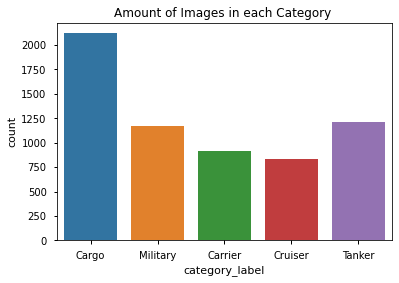

In [ ]:
sns.countplot(x='category_label' , data=train_df).set_title('Amount of Images in each Category ')
plt.savefig('Countplot_cat.png');

Here we create our generators for our train and validation sets, which are specified by the subset parameter. If we want to augment the images in the future we will need to be sure to create a seperate data_generator to be used only on the training set, as we do not want to augment images in our validation set too.

In [ ]:

train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(64, 64),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(64,64),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)

# test_data_generator= ImageDataGenerator(rescale= 1./255.)

# test_generator= data_generator.flow_from_dataframe(
#     dataframe= test_df, directory= 'test_ApKoW4T.csv', x_col='image', y_col= None, subset= 'validation', target_size=(64,64),
#      batch_size= 29, seed= 42, shuffle= False,  class_mode= None, validate_filenames=False
# )

Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:
#Examining the classes
train_generator.labels[:10]
lst=train_generator.labels

In [ ]:
#examining the Classes
train_generator.class_indices

{'Cargo': 0, 'Carrier': 1, 'Cruiser': 2, 'Military': 3, 'Tanker': 4}

In [ ]:
imgs, lbl = next(iter(train_generator))

##First CNN Simple Model
 The following code creates a function which contains our first simple model. Optimizes for accuracy, and the output layer uses the sigmoid activation just to see what results we get (the following models will all employ softmax at the output layers).
 

In [ ]:
def prepare_model():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(Flatten())
  model.add(Dense(5, activation= 'sigmoid'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model


In [ ]:
simple_model= prepare_model()
simple_model.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size,
                    epochs= 3  
                    )

Epoch 1/3
161/161 [==============================] - 2035s 13s/step - loss: 2.8208 - accuracy: 0.3552 - val_loss: 1.2700 - val_accuracy: 0.5003
Epoch 2/3
161/161 [==============================] - 10s 63ms/step - loss: 0.9516 - accuracy: 0.6667 - val_loss: 1.1358 - val_accuracy: 0.5810
Epoch 3/3
161/161 [==============================] - 10s 62ms/step - loss: 0.6080 - accuracy: 0.8124 - val_loss: 1.1097 - val_accuracy: 0.5823


In [ ]:
 simple_model.history.history

{'accuracy': [0.419790118932724, 0.6686695218086243, 0.8118025660514832],
 'loss': [1.7663304805755615, 0.9152520895004272, 0.5880222916603088],
 'val_accuracy': [0.5003253221511841, 0.5810019373893738, 0.5823031663894653],
 'val_loss': [1.2700204849243164, 1.1358304023742676, 1.1096621751785278]}

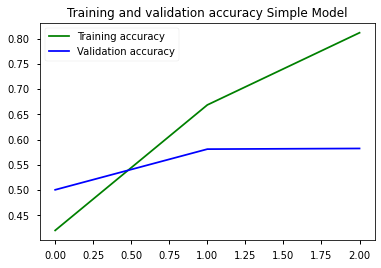

<Figure size 432x288 with 0 Axes>

In [ ]:
acc= simple_model.history.history
acc = simple_model.history.history['accuracy']
val_acc = simple_model.history.history['val_accuracy']
loss = simple_model.history.history['loss']
val_loss = simple_model.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Simple Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_sm')
plt.show();

As we can see from the graph above, clearly our model is overfitting, giving the high training accuracy and low validation accuracy. 

In [ ]:
train_generator.batch_size

29

In [ ]:
validation_generator.class_indices

{'Cargo': 0, 'Carrier': 1, 'Cruiser': 2, 'Military': 3, 'Tanker': 4}

In [ ]:
Y_pred = simple_model.predict(validation_generator, validation_generator.n // validation_generator.batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tanker']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [ ]:

from tqdm import tqdm

In [ ]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [ ]:
# Store the data in X_train, y_train variables by iterating over the batches
train_generator.reset()
X_train, y_train = next(train_generator)
for i in tqdm(range(int(162/28))):
  img, label = next(train_generator)
  X_train = np.append(X_train, img, axis=0 )
  y_train = np.append(y_train, label, axis=0)
print(X_train.shape, y_train.shape)

100%|██████████| 5/5 [00:00<00:00, 18.63it/s]

(174, 64, 64, 3) (174, 5)


In [ ]:
simple_model.predict_classes(X_test, batch_size= 29, verbose=1)

1/1 [==============================] - 0s 14ms/step


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([4, 2, 0, 2, 4, 0, 0, 0, 1, 1, 4, 3, 0, 1, 4, 0, 3, 3, 2, 2, 0, 0,
       4, 4, 1, 0, 0, 1, 0])

In [ ]:
>>> import matplotlib.pyplot as plt  
>>> from sklearn.datasets import make_classification
>>> from sklearn.metrics import plot_confusion_matrix


In [ ]:
print('After Epoch')
#Confution Matrix and Classification Report
Y_pred = simple_model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tanker']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
##TRY THIS WHEN YOU HAVE TIME


After Epoch


KeyboardInterrupt: ignored



## Model 2

This next model will use 'softmax' activation at the output layer instead of 'sigmoid' activation to see if accuracy improves, since softmax does better than sigmoid with multiclass problems. We will also let it train longer at 10 epochs.

In [ ]:
def prepare_model():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(Flatten())
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model


In [ ]:
model_2= prepare_model()
model_2.fit(train_generator, 
                    validation_data= validation_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size,
                    epochs= 10  
                    )

Epoch 1/10
161/161 [==============================] - 11s 62ms/step - loss: 3.3227 - accuracy: 0.3220 - val_loss: 1.1904 - val_accuracy: 0.5332
Epoch 2/10
161/161 [==============================] - 10s 61ms/step - loss: 0.8491 - accuracy: 0.6834 - val_loss: 1.1343 - val_accuracy: 0.5541
Epoch 3/10
161/161 [==============================] - 10s 64ms/step - loss: 0.5509 - accuracy: 0.8365 - val_loss: 1.2521 - val_accuracy: 0.5417
Epoch 4/10
161/161 [==============================] - 11s 66ms/step - loss: 0.3477 - accuracy: 0.9151 - val_loss: 1.2461 - val_accuracy: 0.5828
Epoch 5/10
161/161 [==============================] - 11s 68ms/step - loss: 0.2072 - accuracy: 0.9599 - val_loss: 1.2637 - val_accuracy: 0.5874
Epoch 6/10
161/161 [==============================] - 10s 64ms/step - loss: 0.1206 - accuracy: 0.9863 - val_loss: 1.3344 - val_accuracy: 0.5906
Epoch 7/10
161/161 [==============================] - 11s 66ms/step - loss: 0.0774 - accuracy: 0.9942 - val_loss: 1.3969 - val_accuracy:

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
flatten_1 (Flatten)          (None, 123008)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 615045    
Total params: 615,941
Trainable params: 615,941
Non-trainable params: 0
_________________________________________________________________


The training accuracy improved from 80% to 99%! However definitely still overfitting. 




##Model 3

Adding some more layers. We might have to sacrifice some training accuracy in order to improve our validation accuracy and stop overfitting.

In [ ]:
def prepare_model_3():
  model= Sequential()
  model.add(Conv2D(32, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [ ]:
#lets try 15 epochs this time
model_3= prepare_model_3()
model_3.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=15)



Epoch 1/15
161/161 [==============================] - 11s 62ms/step - loss: 1.4233 - accuracy: 0.3891 - val_loss: 1.1469 - val_accuracy: 0.5684
Epoch 2/15
161/161 [==============================] - 10s 61ms/step - loss: 1.0316 - accuracy: 0.5853 - val_loss: 0.9755 - val_accuracy: 0.6063
Epoch 3/15
161/161 [==============================] - 10s 65ms/step - loss: 0.9133 - accuracy: 0.6339 - val_loss: 0.9573 - val_accuracy: 0.6213
Epoch 4/15
161/161 [==============================] - 11s 66ms/step - loss: 0.7881 - accuracy: 0.6872 - val_loss: 0.9062 - val_accuracy: 0.6402
Epoch 5/15
161/161 [==============================] - 10s 64ms/step - loss: 0.6917 - accuracy: 0.7300 - val_loss: 0.8587 - val_accuracy: 0.6623
Epoch 6/15
161/161 [==============================] - 10s 61ms/step - loss: 0.6119 - accuracy: 0.7796 - val_loss: 0.8395 - val_accuracy: 0.6767
Epoch 7/15
161/161 [==============================] - 10s 60ms/step - loss: 0.5562 - accuracy: 0.7946 - val_loss: 0.7948 - val_accuracy:

In comparison to Model 2, Model 3 has added a couple more covolutional layers on which to train on. Additionally Model 3 ran for 15 epochs, reaching a 
training accuracy of 99% and validation acc of roughly 70%.

The model is still overfitting. However at least the validation accurary has improved by 10%. 




________

##Model 4

Lets make this CNN a little deeper and add some more hidden layers...

In [ ]:
def prepare_model_4():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape=(64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [ ]:
model_4= prepare_model_4()
model_4.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20)

Epoch 1/20
161/161 [==============================] - 12s 69ms/step - loss: 1.5128 - accuracy: 0.3543 - val_loss: 1.2837 - val_accuracy: 0.4602
Epoch 2/20
161/161 [==============================] - 11s 66ms/step - loss: 1.1176 - accuracy: 0.5274 - val_loss: 1.1385 - val_accuracy: 0.5007
Epoch 3/20
161/161 [==============================] - 10s 65ms/step - loss: 0.9087 - accuracy: 0.6173 - val_loss: 0.8861 - val_accuracy: 0.6493
Epoch 4/20
161/161 [==============================] - 10s 63ms/step - loss: 0.7715 - accuracy: 0.6946 - val_loss: 0.7576 - val_accuracy: 0.6904
Epoch 5/20
161/161 [==============================] - 10s 62ms/step - loss: 0.6898 - accuracy: 0.7266 - val_loss: 0.7334 - val_accuracy: 0.7145
Epoch 6/20
161/161 [==============================] - 10s 62ms/step - loss: 0.6120 - accuracy: 0.7568 - val_loss: 0.6393 - val_accuracy: 0.7360
Epoch 7/20
161/161 [==============================] - 10s 64ms/step - loss: 0.4881 - accuracy: 0.8140 - val_loss: 0.6383 - val_accuracy:

In comparison to Model 3, Model 4 has added a couple more covolutional layers on which to train on. Additionally Model 4 ran for 20 epochs, reaching a 
training accuracy of 99% and validation acc of 78%.

The model is still overfitting. However, at least the validation accurary has improved by 8%. 

Next lets try adding some regularization layers in order to prevent the model from overfitting. To help curb this issue we will add some dropout layers.



##Model 5


Next lets try adding some regularization layers in order to prevent the model from overfitting. To help curb this issue we will add some dropout layers.

In [ ]:
#create early stopping with a patience of 10 and saving our best model
cnn_early_stop= [EarlyStopping(monitor='val_loss', patience= 10), 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_loss', save_best_only=True)]

In [ ]:
def prepare_model_5():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.1))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [ ]:
model_5= prepare_model_5()
model_5.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20, callbacks= cnn_early_stop
            
            )

Epoch 1/20
161/161 [==============================] - 12s 65ms/step - loss: 1.5467 - accuracy: 0.3235 - val_loss: 1.3687 - val_accuracy: 0.3774
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 2/20
161/161 [==============================] - 10s 63ms/step - loss: 1.3012 - accuracy: 0.4310 - val_loss: 1.2259 - val_accuracy: 0.4733
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 3/20
161/161 [==============================] - 11s 67ms/step - loss: 1.1459 - accuracy: 0.5050 - val_loss: 1.0210 - val_accuracy: 0.5698
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 4/20
161/161 [==============================] - 11s 68ms/step - loss: 0.9904 - accuracy: 0.5907 - val_loss: 0.8850 - val_accuracy: 0.6428
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 5/20
161/161 [==============================] - 10s 63ms/step - lo

In [ ]:
model_5.history.history

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)      

##Model 6


Perhaps, we are not regularizing enough... Model 6 increases the Dropout from 0.1 to 0.2- 0.3.

In [ ]:
def prepare_model_6():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (64,64,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.2))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.2))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.3))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [ ]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=20, callbacks= cnn_early_stop)

Epoch 1/20
161/161 [==============================] - 12s 70ms/step - loss: 1.5367 - accuracy: 0.3403 - val_loss: 1.3341 - val_accuracy: 0.4120
Epoch 2/20
161/161 [==============================] - 11s 67ms/step - loss: 1.3044 - accuracy: 0.4361 - val_loss: 1.2425 - val_accuracy: 0.4413
Epoch 3/20
161/161 [==============================] - 10s 64ms/step - loss: 1.1578 - accuracy: 0.4817 - val_loss: 1.0850 - val_accuracy: 0.5600
Epoch 4/20
161/161 [==============================] - 11s 66ms/step - loss: 1.0203 - accuracy: 0.5689 - val_loss: 0.8289 - val_accuracy: 0.6578
Epoch 5/20
161/161 [==============================] - 11s 66ms/step - loss: 0.8580 - accuracy: 0.6447 - val_loss: 0.8006 - val_accuracy: 0.6675
Epoch 6/20
161/161 [==============================] - 10s 65ms/step - loss: 0.7948 - accuracy: 0.6662 - val_loss: 0.7171 - val_accuracy: 0.6975
Epoch 7/20
161/161 [==============================] - 10s 62ms/step - loss: 0.7064 - accuracy: 0.7094 - val_loss: 0.7567 - val_accuracy:

In [ ]:
print("The best model training accurary is: ", (round(model_6.history.history['accuracy'][19]*100,2)))
print("The best model validation accurary is: ", (round(model_6.history.history['val_accuracy'][19]*100,2)))

The best model training accurary is:  91.12
The best model validation accurary is:  77.71


In [ ]:
ships_dict

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}

In [ ]:
# Y_pred = model_6.predict(validation_generator, validation_generator.n // validation_generator.batch_size)
# y_pred = np.argmax(Y_pred, axis=1)
# print('Confusion Matrix')
# print(confusion_matrix(validation_generator.classes, y_pred))
# print('Classification Report')
# target_names = ['Cargo', 'Military', 'Carrier', 'Cruise', 'Tanker']
# print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
batch_size = 20
num_of_test_samples = 70
predictions = model_6.predict_generator(validation_generator,  num_of_test_samples // batch_size+1)

y_pred = np.argmax(predictions, axis=1)

true_classes = validation_generator.class_indices

class_labels = list(validation_generator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(validation_generator.classes, y_pred))

report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

In [ ]:
model_6.predict_on_batch(

<bound method Model.predict_on_batch of <keras.engine.sequential.Sequential object at 0x7f9f2c2e2d50>>

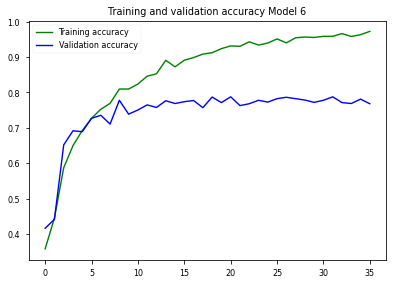

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

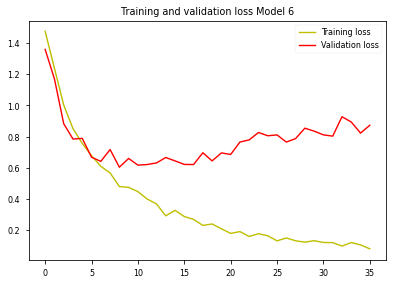

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss Model 6')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_')
plt.show();

Tried model 6 again with 100 epochs instead of 20. To see if training longer makes any difference.

In [ ]:
cnn_early_stop= [EarlyStopping(monitor='val_accuracy', patience= 15), 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_accuracy', save_best_only=True)]

In [ ]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=100, callbacks= cnn_early_stop)
            

Epoch 1/100
161/161 [==============================] - 12s 65ms/step - loss: 1.5296 - accuracy: 0.3425 - val_loss: 1.3599 - val_accuracy: 0.4166
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 2/100
161/161 [==============================] - 10s 63ms/step - loss: 1.2964 - accuracy: 0.4234 - val_loss: 1.1705 - val_accuracy: 0.4420
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 3/100
161/161 [==============================] - 10s 63ms/step - loss: 1.0677 - accuracy: 0.5417 - val_loss: 0.8825 - val_accuracy: 0.6519
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 4/100
161/161 [==============================] - 10s 63ms/step - loss: 0.8771 - accuracy: 0.6370 - val_loss: 0.7838 - val_accuracy: 0.6917
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 5/100
161/161 [==============================] - 10s 63ms/step

In [ ]:
print("The model training accuracy is: ", (round(model_6.history.history['accuracy'][-1]*100,2)))
print("The model validation accuracy is: ", (round(model_6.history.history['val_accuracy'][-1]*100,2)))

The model training accurary is:  97.79
The model validation accurary is:  78.01


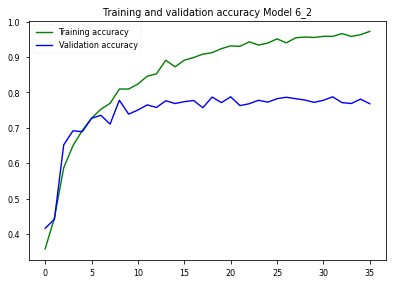

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6_2')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

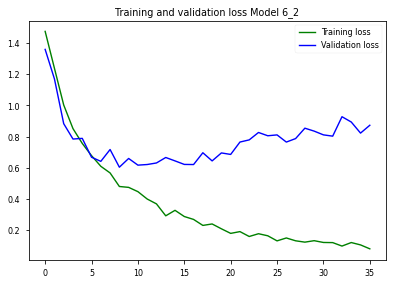

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss Model 6_2')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_')
plt.show();

In an attempt to combat overfitting, we will use our model 6 on **augmented** images. And also increase the dropout regularization to 0.5. To do this we must create a seperate data generator so that the validation data is not also transformed.

IMAGE AUGMENTATIONS: 
- HorizontalFlip
- Contrast
- Brightness
- HueSaturationValue 
- ShiftScaleRotate




In [ ]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.2,1.2])

In [ ]:
train_generator= data_generator_aug.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:
def prepare_model_6():
  model= Sequential()
  #Layer 1
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu', input_shape= (128,128,3)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 2
  model.add(Conv2D(64, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 3
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Dropout(0.5))
  #Layer 4
  model.add(Conv2D(128, kernel_size= (3,3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  #Layer 5
  model.add(Dense(512, activation= 'relu'))
  #Layer 6
  model.add(Dense(5, activation= 'softmax'))
  model.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
  return model

In [ ]:
model_6= prepare_model_6()
model_6.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=30, callbacks= cnn_early_stop
            
            )

In [ ]:
print("The augmented model training accurary is: ", (round(model_6.history.history['accuracy'][-1]*100,2)))
print("The augmented model validation accurary is: ", (round(model_6.history.history['val_accuracy'][-1]*100,2)))

The augmented model training accurary is:  61.74
The augmented model validation accurary is:  65.19


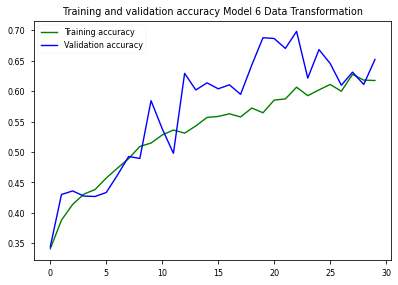

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= model_6.history.history
acc = model_6.history.history['accuracy']
val_acc = model_6.history.history['val_accuracy']
loss = model_6.history.history['loss']
val_loss = model_6.history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy Model 6 Data Transformation')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

This actually seems to have somewhat worked, val accuracy at one point was increasing steadly alongside training accuracy with each epoch. Unfortunately now the model seems to be underfitting.... -_-

##Using Pretrained Models

Lets give transfer learning an attempt to see if that can improve our accuracy.

### VGG16 Pretrained Model

To use the VGG16 model, we change our image shape to 128 instead of 64.

In [ ]:
train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)

Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:
vgg16= VGG16(input_shape= (128,128, 3), include_top= False, weights= 'imagenet')

for layer in vgg16.layers:
  layer.trainable=False

vgg16.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

In [ ]:

model = tf.keras.models.Sequential([
    vgg16,
    
    Flatten(),
    Dense(512,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),

    Dense(128,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 8192)              0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 512)               4194816   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 512)               2048      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 512)               0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 128)               65664     
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 128)               5

In [ ]:
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
history= model.fit(train_generator, validation_data=validation_generator, epochs=10)


Epoch 1/10
162/162 [==============================] - 17s 89ms/step - loss: 1.4417 - accuracy: 0.4903 - val_loss: 0.7278 - val_accuracy: 0.7166
Epoch 2/10
162/162 [==============================] - 12s 76ms/step - loss: 0.8956 - accuracy: 0.6592 - val_loss: 0.6009 - val_accuracy: 0.7530
Epoch 3/10
162/162 [==============================] - 13s 78ms/step - loss: 0.7412 - accuracy: 0.7255 - val_loss: 0.5653 - val_accuracy: 0.7562
Epoch 4/10
162/162 [==============================] - 13s 81ms/step - loss: 0.6136 - accuracy: 0.7547 - val_loss: 0.5280 - val_accuracy: 0.7844
Epoch 5/10
162/162 [==============================] - 13s 78ms/step - loss: 0.5602 - accuracy: 0.7878 - val_loss: 0.6017 - val_accuracy: 0.7754
Epoch 6/10
162/162 [==============================] - 13s 81ms/step - loss: 0.4996 - accuracy: 0.8125 - val_loss: 0.4725 - val_accuracy: 0.8164
Epoch 7/10
162/162 [==============================] - 13s 81ms/step - loss: 0.4684 - accuracy: 0.8277 - val_loss: 0.5197 - val_accuracy:

After training our data on the VGG16 pretrained model we can see that our accuracy for both training and validation improves quickly, with respective accuracies at 88% and 79% and a lower validation loss. Its clearly overfitting less than others..This model is looking promising.

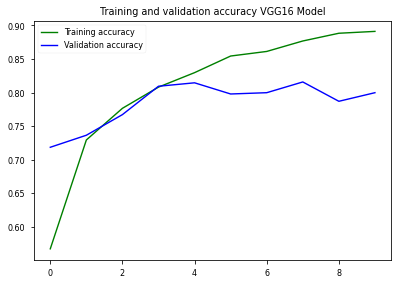

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= history.history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

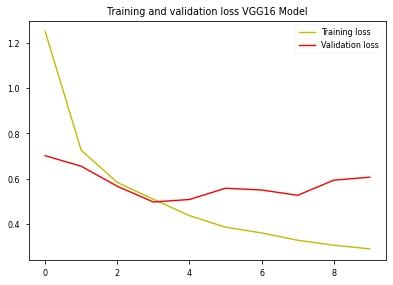

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_loss_vgg16')
plt.show();

In [ ]:
print("The VGG16 pretrained model training accurary is: ", (round(history.history['accuracy'][-1]*100,2)))
print("The VGG16 pretrained model validation accurary is: ", (round(history.history['val_accuracy'][-1]*100,2)))

The VGG16 pretrained model training accurary is:  89.1
The VGG16 pretrained model validation accurary is:  79.97


### Pretrained Model with Data Augmentation

In a final attempt to combat overfitting, we will use our pretrained VGG16 model on **augmented** images. To do this we must create a seperate data generator so that the validation data is not also transformed.

In [ ]:
cnn_checkpoint= [ 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_accuracy', save_best_only=True)]

In [ ]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.2,1.2])

In [ ]:
train_generator= data_generator_aug.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


Now we can train this augemented images on the pretrained model.

In [ ]:
history_2= model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks=cnn_checkpoint)


Epoch 1/30
162/162 [==============================] - 31s 194ms/step - loss: 1.3548 - accuracy: 0.5293 - val_loss: 1.1254 - val_accuracy: 0.5867


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 2/30
162/162 [==============================] - 31s 190ms/step - loss: 1.0862 - accuracy: 0.5660 - val_loss: 0.7340 - val_accuracy: 0.6763


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 3/30
162/162 [==============================] - 31s 194ms/step - loss: 1.0424 - accuracy: 0.5865 - val_loss: 0.5966 - val_accuracy: 0.7710


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 4/30
162/162 [==============================] - 31s 194ms/step - loss: 1.0084 - accuracy: 0.5976 - val_loss: 0.5787 - val_accuracy: 0.7735


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 5/30
162/162 [==============================] - 30s 184ms/step - loss: 1.0178 - accuracy: 0.5905 - val_loss: 0.5783 - val_accuracy: 0.7806


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets


Epoch 6/30
162/162 [==============================] - 31s 192ms/step - loss: 0.9837 - accuracy: 0.6189 - val_loss: 0.5752 - val_accuracy: 0.7761
Epoch 7/30
162/162 [==============================] - 29s 181ms/step - loss: 1.0029 - accuracy: 0.6067 - val_loss: 0.5935 - val_accuracy: 0.7594
Epoch 8/30
162/162 [==============================] - 30s 188ms/step - loss: 0.9719 - accuracy: 0.6153 - val_loss: 0.5726 - val_accuracy: 0.7761
Epoch 9/30
162/162 [==============================] - 30s 184ms/step - loss: 0.9701 - accuracy: 0.6148 - val_loss: 0.5831 - val_accuracy: 0.7652
Epoch 10/30
162/162 [==============================] - 30s 185ms/step - loss: 0.9860 - accuracy: 0.6191 - val_loss: 0.6556 - val_accuracy: 0.7268
Epoch 11/30
162/162 [==============================] - 30s 186ms/step - loss: 0.9589 - accuracy: 0.6110 - val_loss: 0.6090 - val_accuracy: 0.7524
Epoch 12/30
162/162 [==============================] - 30s 184ms/step - loss: 0.9488 - accuracy: 0.6257 - val_loss: 0.6115 - val

Didnt see any improve in val_loss after 15 epochs due to early stop parameter, so the model quit training.

In [ ]:
print("The VGG16 pretrained model 2 training accurary is: ", (round(history_2.history['accuracy'][-1]*100,2)))
print("The VGG16 pretrained model 2 validation accurary is: ", (round(history_2.history['val_accuracy'][-1]*100,2)))

The VGG16 pretrained model 2 training accurary is:  65.45
The VGG16 pretrained model 2 validation accurary is:  74.41


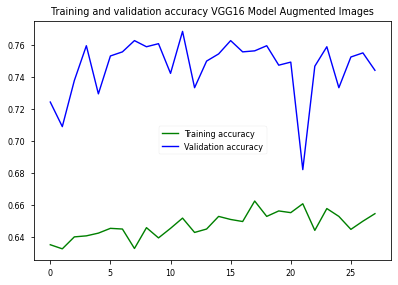

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc= history_2.history
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy VGG16 Model Augmented Images')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_vgg16')
plt.show();

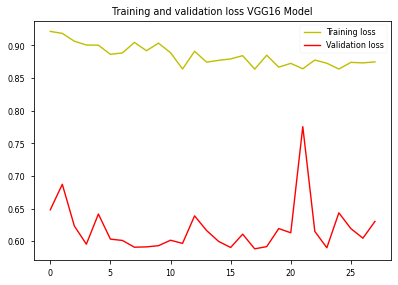

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss VGG16 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_loss_vgg16')
plt.show();

### MobileNetV2


Now lets try using another type of pretrained model: MobileNetV2. We will try to use augmented images in the Data Generator.

In [ ]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.1,0.2], featurewise_center= False, 
                                   samplewise_center= False, featurewise_std_normalization=False, samplewise_std_normalization=False)

In [ ]:

train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(150, 150),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(150,150),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:
early_stopping = [EarlyStopping(monitor='val_accuracy', patience=10), 
                 ModelCheckpoint(filepath='/content/gdrive/My Drive/Capstone/best_models/', monitor='val_accuracy', save_best_only=True)]

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
mobile_model = MobileNetV2(input_shape=(150, 150,3), include_top=False, weights='imagenet')

mobile_model.trainable = True

print("Number of layers in the MobileNetV2 model: ", len(mobile_model.layers))

Number of layers in the MobileNetV2 model:  154


In [ ]:
fine_tune_at = 100
for layer in mobile_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [ ]:
# Create model adding the pre-trained model mobileNetV2, 
# adding GlobalAveragePooling2D layer
model_mnv2= Sequential([mobile_model,
                    GlobalAveragePooling2D(),
                    Dropout(rate=0.5),
                    Dense(5, activation='softmax')])

model_mnv2.compile(loss= 'categorical_crossentropy', optimizer= 'adam', metrics= ['accuracy'])
 

In [ ]:
trained_FT = model_mnv2.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    callbacks=[early_stopping])

model_mnv2.save_weights('weights_FT.h5')

Epoch 1/20
161/161 [==============================] - 23s 117ms/step - loss: 0.7825 - accuracy: 0.7238 - val_loss: 2.2695 - val_accuracy: 0.7176


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 2/20
161/161 [==============================] - 18s 113ms/step - loss: 0.2587 - accuracy: 0.9128 - val_loss: 6.3829 - val_accuracy: 0.5452
Epoch 3/20
161/161 [==============================] - 18s 113ms/step - loss: 0.1950 - accuracy: 0.9289 - val_loss: 3.9326 - val_accuracy: 0.6031
Epoch 4/20
161/161 [==============================] - 18s 114ms/step - loss: 0.1334 - accuracy: 0.9545 - val_loss: 0.8968 - val_accuracy: 0.8705


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 5/20
161/161 [==============================] - 18s 114ms/step - loss: 0.1057 - accuracy: 0.9645 - val_loss: 1.4153 - val_accuracy: 0.8504
Epoch 6/20
161/161 [==============================] - 18s 115ms/step - loss: 0.0987 - accuracy: 0.9705 - val_loss: 5.0232 - val_accuracy: 0.6636
Epoch 7/20
161/161 [==============================] - 18s 112ms/step - loss: 0.1035 - accuracy: 0.9682 - val_loss: 1.4429 - val_accuracy: 0.8478
Epoch 8/20
161/161 [==============================] - 18s 112ms/step - loss: 0.0862 - accuracy: 0.9728 - val_loss: 1.3632 - val_accuracy: 0.8478
Epoch 9/20
161/161 [==============================] - 18s 113ms/step - loss: 0.0594 - accuracy: 0.9813 - val_loss: 1.3502 - val_accuracy: 0.8263
Epoch 10/20
161/161 [==============================] - 18s 112ms/step - loss: 0.0703 - accuracy: 0.9772 - val_loss: 2.0924 - val_accuracy: 0.8133
Epoch 11/20
161/161 [====================

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 14/20
161/161 [==============================] - 18s 113ms/step - loss: 0.0583 - accuracy: 0.9812 - val_loss: 2.2646 - val_accuracy: 0.7502
Epoch 15/20
161/161 [==============================] - 18s 113ms/step - loss: 0.0763 - accuracy: 0.9789 - val_loss: 1.0200 - val_accuracy: 0.8634
Epoch 16/20
161/161 [==============================] - 18s 112ms/step - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.8661 - val_accuracy: 0.8939


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 17/20
161/161 [==============================] - 18s 114ms/step - loss: 0.0397 - accuracy: 0.9852 - val_loss: 1.3824 - val_accuracy: 0.8634
Epoch 18/20
161/161 [==============================] - 18s 112ms/step - loss: 0.0289 - accuracy: 0.9902 - val_loss: 1.5118 - val_accuracy: 0.8360
Epoch 19/20
161/161 [==============================] - 18s 113ms/step - loss: 0.0366 - accuracy: 0.9891 - val_loss: 0.8676 - val_accuracy: 0.9050


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Capstone/best_models/assets
Epoch 20/20
161/161 [==============================] - 18s 114ms/step - loss: 0.0320 - accuracy: 0.9890 - val_loss: 1.3099 - val_accuracy: 0.8979


In [ ]:
 trained_FT.history['val_accuracy']

In [ ]:
print("The MobileNetV2 pretrained model 2 training accurary is: ", (round(trained_FT.history['accuracy'][-1]*100,2)))
print("The MobileNetV2 pretrained model 2 validation accurary is: ", (round(trained_FT.history['val_accuracy'][-1]*100,2)))

The MobileNetV2 pretrained model 2 training accurary is:  99.08
The MobileNetV2 pretrained model 2 validation accurary is:  73.19


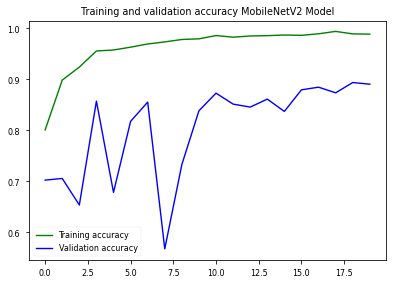

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
acc = model_mnv2.history.history['accuracy']
val_acc = model_mnv2.history.history['val_accuracy']
loss = model_mnv2.history.history['loss']
val_loss = model_mnv2.history.history['val_loss']

epochs= range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy MobileNetV2 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_accuracy_mobilenetv2')
plt.show();

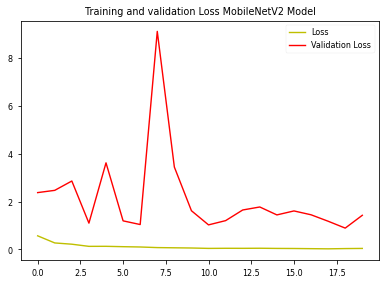

<Figure size 460.8x316.8 with 0 Axes>

In [ ]:
plt.plot(epochs, loss, 'y', label='Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss MobileNetV2 Model')
plt.legend(loc=0)
plt.figure()
plt.style.use('seaborn-paper')
plt.savefig('training_val_loss_mobilenetv2')
plt.show();

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

#### MobileNetV2 Predictions

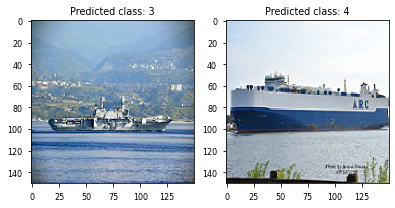

In [ ]:
img1 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/2560213.jpg', target_size=(150, 150))
x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
prediction1 = model_mnv2.predict(x, batch_size=10)

img2 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/2899497.jpg', target_size=(150, 150))
y = image.img_to_array(img2)
y = np.expand_dims(y, axis=0)
prediction2 = model_mnv2.predict(y, batch_size=10)

plt.figure()
plt.subplot(121)
plt.title("Predicted class: " + str(np.argmax(prediction1[0])))
plt.imshow(img1)
plt.subplot(122)
plt.title("Predicted class: " + str(np.argmax(prediction2[0])))
plt.imshow(img2)

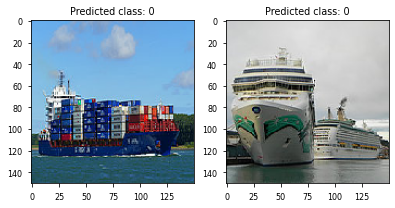

In [ ]:
img1 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/2896557.jpg', target_size=(150, 150))
x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
prediction1 = model_mnv2.predict(x, batch_size=10)

img2 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/1414706.jpg', target_size=(150, 150))
y = image.img_to_array(img2)
y = np.expand_dims(y, axis=0)
prediction2 = model_mnv2.predict(y, batch_size=10)

plt.figure()
plt.subplot(121)
plt.title("Predicted class: " + str(np.argmax(prediction1[0])))
plt.imshow(img1)
plt.subplot(122)
plt.title("Predicted class: " + str(np.argmax(prediction2[0])))
plt.imshow(img2);

In [ ]:
prediction2_df = pd.DataFrame(prediction2)
prediction2_df

,0,1,2,3,4
0,1.0,1.391458e-24,6.470454e-27,7.317159e-24,5.614193e-19


In [ ]:
prediction2_df = pd.DataFrame(prediction2)
prediction2_df

,0,1,2,3,4
0,1.0,1.391458e-24,6.470454e-27,7.317159e-24,5.614193e-19


In [ ]:
ships_dict

{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}

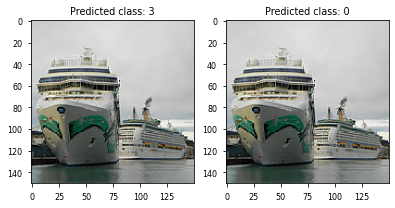

In [ ]:
img1 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/1414706.jpg', target_size=(150, 150))
x = image.img_to_array(img1)
x = np.expand_dims(x, axis=0)
prediction1 = model.predict(x, batch_size=10)

img2 = image.load_img('/content/gdrive/My Drive/Kaggle/train/images/1414706.jpg', target_size=(150, 150))
y = image.img_to_array(img2)
y = np.expand_dims(y, axis=0)
prediction2 = model_mnv2.predict(y, batch_size=10)

plt.figure()
plt.subplot(121)
plt.title("Predicted class: " + str(np.argmax(prediction1[0])))
plt.imshow(img1)
plt.subplot(122)
plt.title("Predicted class: " + str(np.argmax(prediction2[0])))
plt.imshow(img2);

In [ ]:
prediction1_df = pd.DataFrame(prediction1)
prediction1_df

,0,1,2,3,4
0,0.000016,0.000017,0.000024,0.997812,0.002131


In [ ]:
prediction2_df = pd.DataFrame(prediction2)
prediction2_df

,0,1,2,3,4
0,1.0,1.391458e-24,6.470454e-27,7.317159e-24,5.614193e-19


In [ ]:
prediction2

array([[1.0000000e+00, 1.3914579e-24, 6.4704536e-27, 7.3171590e-24,
        5.6141927e-19]], dtype=float32)

In [ ]:
prediction2_df = pd.DataFrame(prediction2)
prediction2_df

,0,1,2,3,4
0,1.0,1.391458e-24,6.470454e-27,7.317159e-24,5.614193e-19


In [ ]:
ships_dict


{1: 'Cargo', 2: 'Military', 3: 'Carrier', 4: 'Cruise', 5: 'Tanker'}

In [ ]:
ship_labels.head(40)

### EfficientNet

In [ ]:
from tensorflow import keras

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

In [ ]:
data_generator=ImageDataGenerator(rescale=1./255., validation_split=0.25)

In [ ]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, fill_mode='nearest', 
                                   width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, 
                                   brightness_range= [0.4, 1.2], zoom_range=[0.2,1.2])

In [ ]:

train_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(128, 128),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(128,128),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:

enet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(128,128,3))

for layer in enet_model.layers:
  layer.trainable=False
enet_model.summary()

In [ ]:

model = tf.keras.models.Sequential([
    enet_model,
    
    Flatten(),
    Dense(512 ,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax'), 
    Flatten()
])
model.summary()

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss= 'categorical_crossentropy')

In [ ]:
history_3= model.fit(train_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
162/162 [==============================] - 20s 87ms/step - loss: 2.2086 - accuracy: 0.2218 - val_loss: 4.3594 - val_accuracy: 0.3340
Epoch 2/20
162/162 [==============================] - 13s 79ms/step - loss: 1.9074 - accuracy: 0.2499 - val_loss: 1.8425 - val_accuracy: 0.3340
Epoch 3/20
162/162 [==============================] - 13s 79ms/step - loss: 1.7839 - accuracy: 0.2768 - val_loss: 1.8654 - val_accuracy: 0.2041
Epoch 4/20
162/162 [==============================] - 13s 82ms/step - loss: 1.7194 - accuracy: 0.2755 - val_loss: 1.5630 - val_accuracy: 0.3340
Epoch 5/20
162/162 [==============================] - 14s 84ms/step - loss: 1.6653 - accuracy: 0.3007 - val_loss: 1.5541 - val_accuracy: 0.3340
Epoch 6/20
162/162 [==============================] - 13s 81ms/step - loss: 1.6199 - accuracy: 0.3144 - val_loss: 1.5531 - val_accuracy: 0.3340
Epoch 7/20
162/162 [==============================] - 13s 79ms/step - loss: 1.6092 - accuracy: 0.3105 - val_loss: 1.5549 - val_accuracy:




### InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inceptionv3= InceptionV3(input_shape=(150,150,3), 
                         include_top= False, 
                         weights= 'imagenet')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in inceptionv3.layers:
  layer.trainable=False

In [ ]:
x=layers.Flatten()(inceptionv3.output)
x=layers.Dense(1024, activation= 'relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(5, actiation= 'softmax')(x)

model= Model(inceptionv3.input,x)
model.compile(optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
data_generator_aug= ImageDataGenerator(rescale= 1./255., validation_split=0.25, rotation_range=20, 
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range= 0.2, horizontal_flip=True, 
                                    zoom_range= 0.2)

In [ ]:
train_generator= data_generator_aug.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'training', target_size=(150, 150),
    batch_size=29, seed= 42, shuffle= True,  class_mode='categorical', #validate_filenames=False
)
validation_generator= data_generator.flow_from_dataframe(
    dataframe=train_df, directory= src_path_train, x_col='image', y_col= 'category_label', subset= 'validation', target_size=(150,150),
     batch_size= 29, seed= 42, shuffle= False,  class_mode='categorical', #validate_filenames=False
)


Found 4689 validated image filenames belonging to 5 classes.
Found 1563 validated image filenames belonging to 5 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.939):
      print('Reached high accuracy so stopped training!')
      self.model.stop_training= True

In [ ]:
callbacks= myCallback()
model.fit(train_generator, 
                    validation_data= validation_generator, 
                    steps_per_epoch= train_generator.n//train_generator.batch_size,
                    validation_steps= validation_generator.n//validation_generator.batch_size, 
                    epochs=60, callbacks= [callbacks])

Epoch 1/60
161/161 [==============================] - 36s 223ms/step - loss: 0.7357 - accuracy: 0.7112 - val_loss: 0.5117 - val_accuracy: 0.7977
Epoch 2/60
161/161 [==============================] - 34s 212ms/step - loss: 0.7000 - accuracy: 0.7273 - val_loss: 0.4905 - val_accuracy: 0.8081
Epoch 3/60
161/161 [==============================] - 34s 213ms/step - loss: 0.6591 - accuracy: 0.7358 - val_loss: 0.5422 - val_accuracy: 0.7736
Epoch 4/60
161/161 [==============================] - 34s 210ms/step - loss: 0.6695 - accuracy: 0.7421 - val_loss: 0.4769 - val_accuracy: 0.8120
Epoch 5/60
161/161 [==============================] - 35s 215ms/step - loss: 0.6671 - accuracy: 0.7418 - val_loss: 0.4772 - val_accuracy: 0.8126
Epoch 6/60
161/161 [==============================] - 34s 208ms/step - loss: 0.6715 - accuracy: 0.7417 - val_loss: 0.5401 - val_accuracy: 0.7775
Epoch 7/60
161/161 [==============================] - 35s 216ms/step - loss: 0.6638 - accuracy: 0.7433 - val_loss: 0.4672 - val_ac

## Using Lime

In [ ]:
!pip install lime


     |████████████████████████████████| 275 kB 7.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ece1a53cec6e4d113f2b5253c7d6288258c3e078dd75cd569ea2c493f17479f7
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
inet_model = inc_net.InceptionV3()


96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

49152/35363 [=========================================] - 0s 0us/step
('n03095699', 'container_ship', 0.82451034)
('n03216828', 'dock', 0.0071801473)
('n03673027', 'liner', 0.003936953)
('n04606251', 'wreck', 0.0037549452)
('n03947888', 'pirate', 0.001796753)


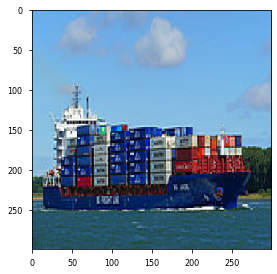

In [ ]:
images = transform_img_fn([os.path.join('/content/gdrive/My Drive/Kaggle/train/images/2896557.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:

explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 15.8 s, sys: 607 ms, total: 16.4 s
Wall time: 16.7 s


In [ ]:
from skimage.segmentation import mark_boundaries

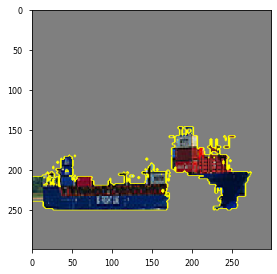

In [ ]:

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

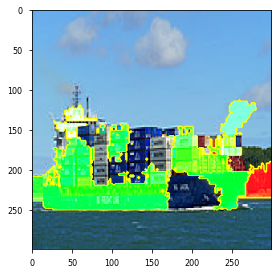

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

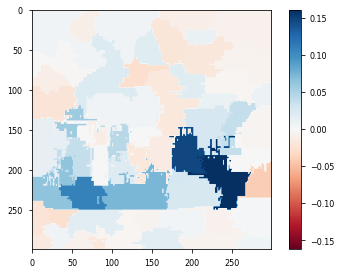

In [ ]:

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [ ]:
train_df[400:420]

('n03673027', 'liner', 0.51991826)
('n03216828', 'dock', 0.105335124)
('n09332890', 'lakeside', 0.0643921)
('n09193705', 'alp', 0.011719126)
('n02687172', 'aircraft_carrier', 0.009095995)


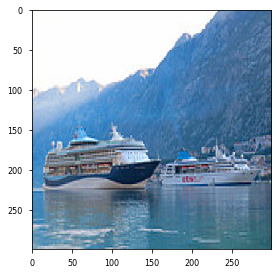

In [ ]:
images = transform_img_fn([os.path.join('/content/gdrive/My Drive/Kaggle/train/images/2882034.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)

In [ ]:

%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(images[0].astype('double'), inet_model.predict, top_labels=5, hide_color=0, num_samples=1000)


CPU times: user 15.4 s, sys: 478 ms, total: 15.9 s
Wall time: 16.1 s


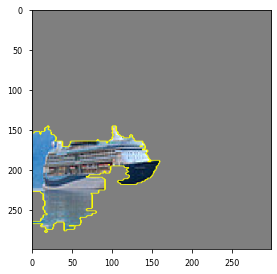

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

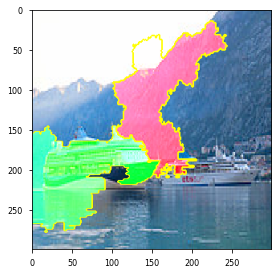

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

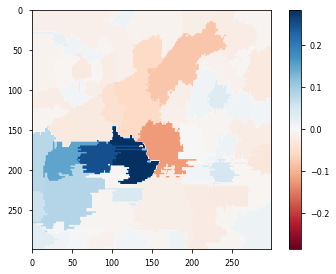

In [ ]:

#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

##Summary

 **What worked**


> In trying to improve the accuracy scores, the following seemed to make a difference, most of which is intuitive:

*   Add more layers
*   Adding stronger regularization (though not a huge improvement)
*   Using a pretrained model with established weights (VGG16)
*   Using a pretrained model on transformed images

 **What didnt work**

*   Training models for longer
*   But also not training models for long enough on transformed images.
*   Regularizing (when the dropout layers were not strong enough)












## Conclusions:


 **Overall**

 The best preforming model was the pretrained MobileNetV2 model on non transformed images. With a training accuracy of 99% and a validation accuracy of 89% this model is the least overfit.
 

**Next Steps**
 

-Address Class Imbalances​

-Experiment with Other Pretrained Models​

-App Deployment 